# Reinforcement Learning – Project 1 – Sam Linderoth


*Acknowledgement: I have used an LLM to generate code for the plots. The problem implementation and solutions have, however, been done by me personally.*

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import random
from IPython.display import HTML

random.seed(900118)

# Dynamic Programming

We begin by remodeling the MDP somewhat from the problem statement; we have three states S = {pristine, worn, broken}. Furthermore, we have three actions A = {continue, repair, replace}.

In the first two states, pristine and worn, we are faced with the choice of two different actions: repair at cost R, or continue until degradation to broken. In the third state, broken, the **only** choice of action is to replace the machine at cost Q.

The policy for the state broken is therefore somewhat arbitrary, as there is only one action available. It is also somewhat arbitrary in the state pristine, as repairing does not change the transition probability (i.e. the risk that the machine will degrade), but we still let the action 'repair' be available in that state so that our agent has more to learn. What matters the most, however is whether we should repair or not in the worn state.

In the following, we will assume that the reward C in the pristine stage and the reward C/2 in the worn state is delivered even though a state transition takes place. That is, the last action still generates a reward within the current state, and the degradation takes place *after* this.

The parameters of the process can be illustrated as in Table 1.

In [4]:
# Define the data
data = [
    ["pristine", "continue", "pristine", "1-θ", "C"],
    ["pristine", "continue", "worn", "θ", "C"],
    ["pristine", "repair", "pristine", "1", "-R"],
    ["worn", "continue", "worn", "1-θ", "C/2"],
    ["worn", "continue", "broken", "θ", "C/2"],
    ["worn", "repair", "pristine", "1", "-R"],
    ["broken", "replace", "pristine", "1", "-Q"]
]

# Define the title
table_title = "Table 1: MDP Model"

# Create HTML table with title
html_table = f"""
<table style="border-collapse: collapse; width: 100%;">
  <caption style="caption-side: top; text-align: center; font-weight: bold; font-size: 1.2em; margin-bottom: 10px;">
    {table_title}
  </caption>
  <tr style="background-color: #f2f2f2;">
    <th style="border: 1px solid #ddd; padding: 8px; text-align: center;">State_{{t}}</th>
    <th style="border: 1px solid #ddd; padding: 8px; text-align: center;">Action</th>
    <th style="border: 1px solid #ddd; padding: 8px; text-align: center;">State_{{t+1}}</th>
    <th style="border: 1px solid #ddd; padding: 8px; text-align: center;">p(s_{{t+1}} | s_{{t}}, a)</th>
    <th style="border: 1px solid #ddd; padding: 8px; text-align: center;">r(s_{{t}}, a)</th>
  </tr>
"""

for row in data:
    html_table += f"""
  <tr>
    <td style="border: 1px solid #ddd; padding: 8px; text-align: center;">{row[0]}</td>
    <td style="border: 1px solid #ddd; padding: 8px; text-align: center;">{row[1]}</td>
    <td style="border: 1px solid #ddd; padding: 8px; text-align: center;">{row[2]}</td>
    <td style="border: 1px solid #ddd; padding: 8px; text-align: center;">{row[3]}</td>
    <td style="border: 1px solid #ddd; padding: 8px; text-align: center;">{row[4]}</td>
  </tr>
"""

html_table += "</table>"

# Display the HTML table
HTML(html_table)

State_{t},Action,State_{t+1},"p(s_{t+1} | s_{t}, a)","r(s_{t}, a)"
pristine,continue,pristine,1-θ,C
pristine,continue,worn,θ,C
pristine,repair,pristine,1,-R
worn,continue,worn,1-θ,C/2
worn,continue,broken,θ,C/2
worn,repair,pristine,1,-R
broken,replace,pristine,1,-Q


## Problem 1 – Evaluate the state value function for the policy $\pi(s)$ = continue

We follow equation $(4.4)$ on page 74 of Sutton & Barto. Since the policy is deterministic, the rewards are also deterministic, and there is no need to sum over $\Sigma_{a} \pi(a \vert s)$ or $\Sigma_{r}$ .  In effect, we have

$$
v_{\pi}(s) = \Sigma_{s'} p(s' \vert s, a) [R + \gamma v_{\pi}(s') ].
$$

Assuming parameters $\theta = 0.2, R = 5, C = 4, Q = 10$ and $\gamma = 0.9$, we get

-------
$$
\begin{align*}
v_{\pi}(\text{pristine}) & =  p(s' = \text{pristine} \vert s = \text{pristine}, a = \text{continue}) \cdot [4 + 0.9 v_{\pi}(pristine) ] + p(s' = \text{worn} \vert s = \text{pristine}, a = \text{continue}) \cdot [4 + 0.9 v_{\pi}(worn)] \\
& = 0.8\cdot[4 + 0.9 v_{\pi}(pristine)] + 0.2 \cdot [4 + 0.9 v_{\pi}(worn)]
\end{align*}
$$

-------

$$
\begin{align*}
v_{\pi}(\text{worn}) & =  p(s' = \text{worn} \vert s = \text{worn}, a = \text{continue}) \cdot [2 + 0.9 v_{\pi}(worn) ] + p(s' = \text{broken} \vert s = \text{worn}, a = \text{continue}) \cdot [2 + 0.9 v_{\pi}(broken)] \\
& = 0.8\cdot[2 + 0.9 v_{\pi}(worn)] + 0.2 \cdot [2 + 0.9 v_{\pi}(broken)]
\end{align*}
$$


-------

$$
\begin{align*}
v_{\pi}(\text{broken}) & =  p(s' = \text{pristine} \vert s = \text{broken}, a = \text{replace}) \cdot [-10 + 0.9 v_{\pi}(pristine) ] \\
& = 1 \cdot [-10 + 0.9 v_{\pi}(pristine) ]
\end{align*}
$$

-------

Setting $x = \text{pristine}, y = \text{worn}, z = \text{broken}$ we now have a system of linear equations
$$
\begin{align*}
x & = 0.8\cdot(4 + 0.9x) + 0.2\cdot(4 + 0.9y) \\
y & = 0.8\cdot(2 + 0.9y) + 0.2\cdot(2 + 0.9z) \\
z & = -10 + 0.9x. \\
\end{align*}
$$

The solution to this system is given by
$$
\begin{align*}
x = \frac{28900}{1231} \approx 23.48 \\
y = \frac{9200}{251} \approx 14.3 \\
z = \frac{6040}{251} \approx 11.13. \\
\end{align*}
$$

A note, given that we have modeled the problem slightly differently from what was described in the project description: In case we had set the policy to **repair** in the worn state, the solution to the above system would have been:

$$
\begin{align*}
x = \frac{1550}{59} \approx 26.27 \\
y = \frac{1100}{59} \approx 18.64 \\
z = \frac{805}{59} \approx 13.64.\\
\end{align*}
$$

The reason for showing also these numbers will become obvious as we proceed.

## Problem 2 – Manual value iteration

We follow the value iteration pseudo-code from page 83 of Sutton & Barto, and the state-value calculations for the always-continue policy given above. We set $\gamma = 0.9$

For the state pristine

If repair:

$$
\begin{align*}
& \Sigma_{s', r} p(s', r \vert s = pristine, a = repair)(-5 + \gamma V(s')) \\
& = 1\cdot(-5 + 0.9 V(\text{pristine})) \\
& = -5 + 0.9\cdot 23.48 \\
& \approx 16.32
\end{align*}
$$

If continue:

$$
\begin{align*}
& \Sigma_{s', r} p(s', r \vert s = pristine, a = continue)(4 + \gamma V(s')) \\
& = 0.8\cdot(4 + 0.9 V(\text{pristine})) + 0.2\cdot(4 + 0.9 V(\text{worn})) \\
& = 0.8\cdot(4+ 0.9 \cdot 23.48) + 0.2 \cdot (4+ 0.9 \cdot 14.3) \\
& \approx 23.48
\end{align*}
$$

Since the state-value is set at the maximum, $V(\text{pristine}) = 23.48$.

-----

For the state worn



If repair:

$$
\begin{align*}
& \Sigma_{s', r} p(s', r \vert s = worn, a = repair)(-5 + \gamma V(s')) \\
& = 1\cdot(-5 + 0.9 V(\text{pristine})) \\
& = -5 + 0.9\cdot 23.48 \\
& \approx 16.32
\end{align*}
$$

If continue:

$$
\begin{align*}
& \Sigma_{s', r} p(s', r \vert s = worn, a = continue)(2 + \gamma V(s')) \\
& = 0.8\cdot(2 + 0.9 V(\text{worn})) + 0.2\cdot(2 + 0.9 V(\text{broken})) \\
& = 0.8\cdot(2 + 0.9 \cdot 14.3) + 0.2 \cdot (2+ 0.8 \cdot 11.13) \\
& \approx 14.3
\end{align*}
$$

Since the state-value is set at the maximum, $V(\text{worn}) = 16.32$.

-----

For the state broken


Only action is to replace:

$$
V(\text{broken}) = 1\cdot(-10 + 0.9V(\text{pristine})) \approx 11.13.
$$


-----

In this case, if the threshold of the value iteration had been reached, we would at the end of the algorithm have updated the policy such that $\pi(\text{worn}) = \text{repair}$.

## Problem 3 - Implement code

Now, we implement the problem in code. We will implement both policy iteration (algorithm on page 80 of Sutton & Barto) and value iteration (algorithm on page 83 of Sutton & Barto). Furthermore, we'll apply the three different discount factors $\gamma = \{0.7, 0.8, 0.9 \}$ as suggested.

We'll then print the requested table (for $\gamma = 0.9$) and the learning curve – given as the iterative state-value for the state pristine – for each method and value of gamma.

In [5]:
def value_iteration(P, V, probs, states, actions, rew_func, gamma,
                    max_iter=500_000, eps=1e-6):

    '''
    A function for the value iteration algorithm, as described on page 83 of Sutton & Barto.

    Inputs
    ---------
    P: Policy dict
    V: State-value storage vector
    probs: Transition probability dict
    states: State set (list)
    actions: Action set (list)
    rew_func: Reward function
    gamma: Discount factor
    max_iter: Set max iterations to break loop (default: 500 000)
    eps: Set breaking threshold

    Outputs
    ---------
    V: Updated state-value function
    P: Updated policy
    learning_curve: Learning curve (the value of each state across iterations)
    '''

    # Set learning curve storage dict
    learning_curve = {0: [], 1: [], 2: []}
    iter = 0

    # Begin loop
    while True and iter < max_iter:
        delta = 0
        for state in states:
            v = V[state]
            if state == 2:  # Broken state, handled deterministically: replace and go to pristine state
                V[state] = -Q + gamma * V[0]
            else:
                V[state] = max(np.sum(probs[action][state] * (rew_func[action][state] + gamma * V)) for action in actions[state])
            delta = max(delta, abs(v - V[state]))
            learning_curve[state].append(V[state])
        iter += 1
        if delta < eps:
            break

    # Fetch optimal policy
    for state in states:
        if state == 2:
            P[state] = "replace" # Deterministic choice
        else:
            P[state] = max(actions[state], key=lambda a: np.sum(probs[a][state] * (rew_func[a][state] + gamma * V)))

    return V, P, learning_curve

def policy_iteration(P, V, probs, states, actions, rew_func, gamma,
                    max_iter=500_000, eps=1e-6):

    '''
    A function for the policy iteration algorithm, as described on page 80 of Sutton & Barto.

    Inputs
    ---------
    P: Policy dict
    V: State-value storage vector
    probs: Transition probability dict
    states: State set (list)
    actions: Action set (list)
    rew_func: Reward function
    gamma: Discount factor
    max_iter: Set max iterations to break loop (default: 500 000)
    eps: Set breaking threshold

    Outputs
    ---------
    V: Updated state-value function
    P: Updated policy
    learning_curve: Learning curve (the value of each state across iterations)
    '''

    # Set learning curve storage dict
    learning_curve = {0: [], 1: [], 2: []}
    main_iter = 0

    # Begin main loop
    while True and main_iter < max_iter:

      # Begin policy evaluation loop
      eval_iter = 0
      while True and eval_iter < max_iter:
          delta = 0
          for state in states:
              v = V[state]
              if state == 2:  # Broken state, handled deterministically: replace
                  V[state] = -Q + gamma * V[0]
              else:
                  V[state] = np.sum(probs[P[state]][state] * (rew_func[P[state]][state] + gamma * V))
              delta = max(delta, abs(v - V[state]))
              learning_curve[state].append(V[state])

          # Break policy evaluation loop if stable
          eval_iter += 1
          if delta < eps:
              break

      # Begin policy improvement
      policy_stable = True
      for state in states:

        # Store old action, fetch new max action
        old_action = P[state]
        P[state] = max(actions[state], key=lambda a: np.sum(probs[a][state] * (rew_func[a][state] + gamma * V)))

        # Check if policy has changed, if so then break and return to the beginning of main loop
        if old_action != P[state]:
          policy_stable = False
          break

      # Break main loop if policy is stable
      main_iter += 1
      if policy_stable:
          break

    return V, P, learning_curve

# Define the parameters
theta, R, C, Q, gamma = 0.2, 5, 4, 10, 0.9

# Define the state space
# 0 = pristine, 1 = worn, 2 = broken
states = [0, 1, 2]

# Define the action space
actions = {
    0: ['continue', 'repair'],
    1: ['continue', 'repair'],
    2: ['replace']
}

# Define the transition probability matrices
probs = {
    'continue': np.array([[1-theta, theta, 0],
                          [0, 1-theta, theta],
                          [0, 0, 0]]),

    'repair': np.array([[1, 0, 0],
                        [1, 0, 0],
                        [0, 0, 0]]),

    'replace': np.array([[0, 0, 0],
                         [0, 0, 0],
                         [1, 0, 0]])
}

# Define the reward function
rew_func = {
    'continue': np.array([C, C/2, 0]),
    'repair': np.array([-R, -R, 0]),
    'replace': np.array([0, 0, -Q])
}

In [12]:
# Initialize value functions, policies
V_valueiter = np.zeros(3)
P_valueiter = {0: "continue", 1: "continue", 2: "replace"}

# Initialize value functions, policies
V_policyiter = np.zeros(3)
P_policyiter = {0: "continue", 1: "continue", 2: "replace"}

# Run value iteration
V_valueiter, P_valueuter, lc_vi = value_iteration(P_valueiter, V_valueiter, probs, states, actions, rew_func, gamma = 0.9)

# Run policy iteration
V_policyiter, P_policyiter, lc_pi = policy_iteration(P_policyiter, V_policyiter, probs, states, actions, rew_func, gamma = 0.9)

# Define the title
table_title = "Table 2: Optimal State Values and Optimal Policies for γ = 0.9"

# Create HTML table with title
html_table = f"""
<table style="border-collapse: collapse; width: 100%;">
  <caption style="caption-side: top; text-align: center; font-weight: bold; font-size: 1.2em; margin-bottom: 10px;">
    {table_title}
  </caption>
  <tr style="background-color: #f2f2f2;">
    <th style="border: 1px solid #ddd; padding: 8px; text-align: center;">State</th>
    <th style="border: 1px solid #ddd; padding: 8px; text-align: center;" colspan="2">Value Iteration</th>
    <th style="border: 1px solid #ddd; padding: 8px; text-align: center;" colspan="2">Policy Iteration</th>
  </tr>
  <tr style="background-color: #f2f2f2;">
    <th style="border: 1px solid #ddd; padding: 8px; text-align: center;"></th>
    <th style="border: 1px solid #ddd; padding: 8px; text-align: center;">Value</th>
    <th style="border: 1px solid #ddd; padding: 8px; text-align: center;">Policy</th>
    <th style="border: 1px solid #ddd; padding: 8px; text-align: center;">Value</th>
    <th style="border: 1px solid #ddd; padding: 8px; text-align: center;">Policy</th>
  </tr>
"""

for state in states:
    html_table += f"""
  <tr>
    <td style="border: 1px solid #ddd; padding: 8px; text-align: center;">{state}</td>
    <td style="border: 1px solid #ddd; padding: 8px; text-align: center;">{V_valueiter[state]:.2f}</td>
    <td style="border: 1px solid #ddd; padding: 8px; text-align: center;">{P_valueiter[state]}</td>
    <td style="border: 1px solid #ddd; padding: 8px; text-align: center;">{V_policyiter[state]:.2f}</td>
    <td style="border: 1px solid #ddd; padding: 8px; text-align: center;">{P_policyiter[state]}</td>
  </tr>
"""

html_table += "</table>"

# Display the HTML table
HTML(html_table)

As Table 2 shows, the optimal policy for both methods is to continue in the pristine state (0), repair in the worn state (1), and replace – which is done deterministically – in the broken state (2). Furthermore, the values of each state coincides with the calculations done in the former section.

Now, let's look at the learning curves.

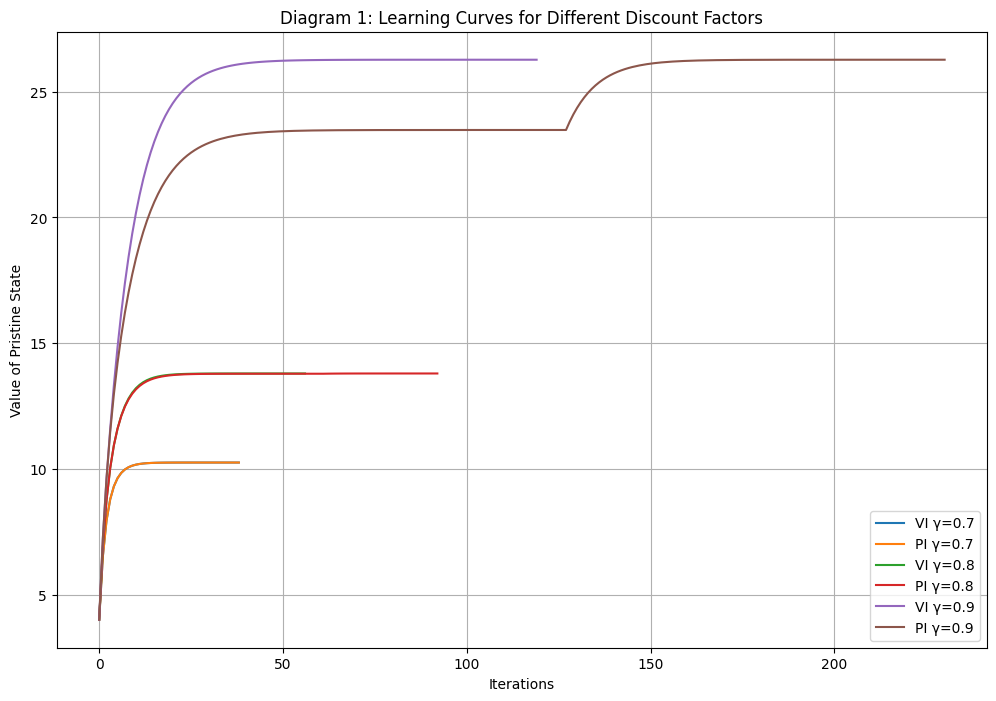

In [10]:
# Initialize value functions, policies
V_valueiter = np.zeros(3)
P_valueiter = {0: "continue", 1: "continue", 2: "replace"}

# Initialize value functions, policies
V_policyiter = np.zeros(3)
P_policyiter = {0: "continue", 1: "continue", 2: "replace"}

discount_factors = [0.7, 0.8, 0.9]

plt.figure(figsize=(12, 8))

for gamma in discount_factors:
    # Initialize value functions, policies
    V_valueiter = np.zeros(3)
    P_valueiter = {0: "continue", 1: "continue", 2: "replace"}

    # Initialize value functions, policies
    V_policyiter = np.zeros(3)
    P_policyiter = {0: "continue", 1: "continue", 2: "replace"}

    V_valueiter, P_valueiter, lc_vi = value_iteration(P_valueiter, V_valueiter, probs, states, actions, rew_func, gamma)
    V_policyiter, P_policyiter, lc_pi = policy_iteration(P_policyiter, V_policyiter, probs, states, actions, rew_func, gamma)

    plt.plot(lc_vi[0], label=f'VI γ={gamma}')
    plt.plot(lc_pi[0], label=f'PI γ={gamma}')

plt.xlabel('Iterations')
plt.ylabel('Value of Pristine State')
plt.title('Diagram 1: Learning Curves for Different Discount Factors')
plt.legend()
plt.grid(True)
plt.show()

As can be noted from Diagram 1, the lower values of $\gamma$ seem to converge faster. The fastest convergence is noted for the lowest value of $\gamma$. An explanation to this is that these strategies places less value on future states, and acts more greedily. As such, they are not as sensitive to policy changes in other states than their own, and focus more on the immediate reward, which remains the same across episodes.

In fact, for $\gamma = 0.7$, the policy in the worn state changes as a result of the focus on more immediate rewards, and suggests that one should continue rather than repair. This is displayed in Table 3 below.

We may also note that the value iteration method seems to converge faster than the policy iteration method for $\gamma = 0.9$, but the difference is almost nonexistent for low values of $\gamma$. These results are not surprising either, as value iteration is a truncated and shorter version of policy iteration, as discussed by Sutton & Barto on page 83-84: "Value iteration effectively combines, in each of its sweeps, one sweep of policy evaluation and one sweep of policy improvement. Faster convergence is often achieved by interposing multiple policy evaluation sweeps between each policy improvement sweep."

In [16]:
# Initialize value functions, policies
V_valueiter = np.zeros(3)
P_valueiter = {0: "continue", 1: "continue", 2: "replace"}

# Initialize value functions, policies
V_policyiter = np.zeros(3)
P_policyiter = {0: "continue", 1: "continue", 2: "replace"}

# Run value iteration
V_valueiter, P_valueuter, lc_vi = value_iteration(P_valueiter, V_valueiter, probs, states, actions, rew_func, gamma = 0.7)

# Run policy iteration
V_policyiter, P_policyiter, lc_pi = policy_iteration(P_policyiter, V_policyiter, probs, states, actions, rew_func, gamma = 0.7)

# Define the title
table_title = "Table 3: Optimal State Values and Optimal Policies for γ = 0.7"

# Create HTML table with title
html_table = f"""
<table style="border-collapse: collapse; width: 100%;">
  <caption style="caption-side: top; text-align: center; font-weight: bold; font-size: 1.2em; margin-bottom: 10px;">
    {table_title}
  </caption>
  <tr style="background-color: #f2f2f2;">
    <th style="border: 1px solid #ddd; padding: 8px; text-align: center;">State</th>
    <th style="border: 1px solid #ddd; padding: 8px; text-align: center;" colspan="2">Value Iteration</th>
    <th style="border: 1px solid #ddd; padding: 8px; text-align: center;" colspan="2">Policy Iteration</th>
  </tr>
  <tr style="background-color: #f2f2f2;">
    <th style="border: 1px solid #ddd; padding: 8px; text-align: center;"></th>
    <th style="border: 1px solid #ddd; padding: 8px; text-align: center;">Value</th>
    <th style="border: 1px solid #ddd; padding: 8px; text-align: center;">Policy</th>
    <th style="border: 1px solid #ddd; padding: 8px; text-align: center;">Value</th>
    <th style="border: 1px solid #ddd; padding: 8px; text-align: center;">Policy</th>
  </tr>
"""

for state in states:
    html_table += f"""
  <tr>
    <td style="border: 1px solid #ddd; padding: 8px; text-align: center;">{state}</td>
    <td style="border: 1px solid #ddd; padding: 8px; text-align: center;">{V_valueiter[state]:.2f}</td>
    <td style="border: 1px solid #ddd; padding: 8px; text-align: center;">{P_valueiter[state]}</td>
    <td style="border: 1px solid #ddd; padding: 8px; text-align: center;">{V_policyiter[state]:.2f}</td>
    <td style="border: 1px solid #ddd; padding: 8px; text-align: center;">{P_policyiter[state]}</td>
  </tr>
"""

html_table += "</table>"

# Display the HTML table
HTML(html_table)

# Monte Carlo

## Problem 1 – Compute G_{t}

We compute $G_t$ usinga discount factor of $\gamma = 0.9$ and view $s_7$ as a terminal state. Computing $G_t$ to a similar fashion as in MC prediction (pseudo-code on page 92 of Sutton & Barto) we get by beginning with $G_7 = 0$:

$$
\begin{align*}
G_{6} & = \gamma G_7 + 10 = 0.9 \cdot 0 + 10 = \textbf{10} \\
G_{5} & = \gamma G_6 -1 = 0.9 \cdot 10 -1 = \textbf{8} \\
G_{4} & = \gamma G_5 -1 = 0.9 \cdot 8 -1 = \textbf{6.2} \\
G_{3} & = \gamma G_4 -1 = 0.9 \cdot 6.2 -1 = \textbf{4.58} \\
G_{2} & = \gamma G_3 -1 = 0.9 \cdot 4.58 -1 = \textbf{3.122} \\
G_{1} & = \gamma G_2 -1 = 0.9 \cdot 3.122 -1 = \textbf{1.8098} \\
G_{0} & = \gamma G_1 -1 = 0.9 \cdot 1.8098 -1 = \textbf{0.62882} \\
\end{align*}
$$

## Problem 2 – Manual MC Prediction

We follow the first-visit MC prediction algorithm on page 92 of Sutton & Barto. Since the episode is already generated, and the states are visited only once in this episode, there is no need to average the state-returns. We have already computed the neccessary $G$:s with a discounting factor of $\gamma = 0.9$ and can now put them into the grid.

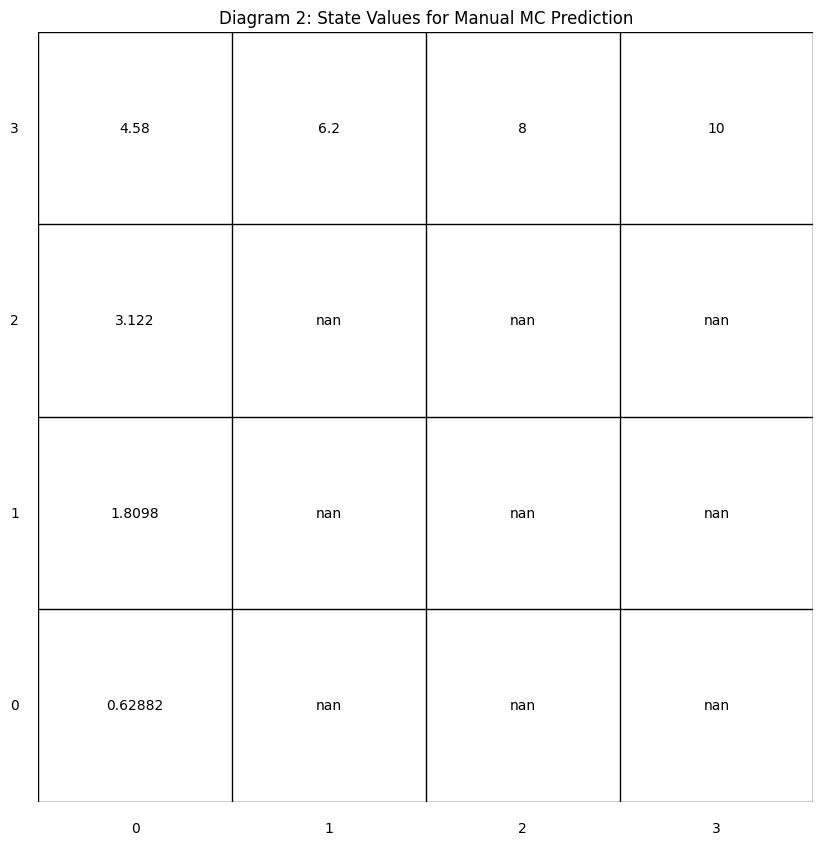

In [ ]:
manual_grid = {(i, j) : 'nan' for i in range(4) for j in range (4)}
manual_grid[(0, 0)] = 0.62882
manual_grid[(0, 1)] = 1.8098
manual_grid[(0, 2)] = 3.122
manual_grid[(0, 3)] = 4.58
manual_grid[(1, 3)] = 6.2
manual_grid[(2, 3)] = 8
manual_grid[(3, 3)] = 10

# Create a new figure
fig, ax = plt.subplots(figsize=(10, 10))

# Hide axes
ax.axis('off')

# Create grid
for i in range(5):
    ax.axhline(y=i, color='black', linewidth=1)
    ax.axvline(x=i, color='black', linewidth=1)

# Add text to cells
for (x, y), direction in manual_grid.items():
    ax.text(x + 0.5, y + 0.5, direction, ha='center', va='center')

# Set limits
ax.set_xlim(0, 4)
ax.set_ylim(0, 4)

# Add coordinates
for i in range(4):
    ax.text(i + 0.5, -0.1, str(i), ha='center', va='top')
    ax.text(-0.1, i + 0.5, str(i), ha='right', va='center')

plt.title('Diagram 2: State Values for Manual MC Prediction')
plt.show()

## Problem 3 – Code implementation

Now, it's time to implement the methods in code. We will do it in the following way:

* Monte Carlo Exploring Starts, First-Visit and Every-Visit (pseudo-code on page 99 of Sutton & Barto)

* e-greedy Monte Carlo with $\epsilon = \{0.05, 0.1, 0.2\}$ (pseudo-code on page 101 of Sutton & Barto)

Both methods will use a discounting factor $\gamma$ of 0.9.

Let's begin by looking at the learning curves, represented as the cumulative average reward in each episode.

In [ ]:
def initialize_lists(actions):

  '''
  A function to initialize storage lists.
  '''

  # Policy dict
  P = {(i, j) : random.choice(actions) for i in range(4) for j in range (4)}
  P[(3, 3)] = 'goal'

  # State-action dict
  Q = {(i, j) : {'left': 0, 'right': 0, 'up' : 0, 'down': 0} for i in range(4) for j in range (4)}

  # State-value dict
  V = {(i, j) : 0 for i in range(4) for j in range (4)}

  # List of state-action returns
  stateaction_returns = {((i, j), action): []
            for i in range(4)
            for j in range(4)
            for action in actions}

  # List of state returns
  state_returns = {(i, j): []
            for i in range(4)
            for j in range(4)}

  # List of episode returns
  episode_reward_storage = []

  return P, Q, V, stateaction_returns, state_returns, episode_reward_storage


def return_function(state_list, action, state):

  '''
  A function to fetch returns/rewards.
  '''

  original_state = state

  if action == 'left':
      state = (state[0] - 1, state[1])
  elif action == 'right':
      state = (state[0] + 1, state[1])
  elif action == 'up':
      state = (state[0], state[1] + 1)
  elif action == 'down':
    state = (state[0], state[1] - 1)

  if state == (3, 3):
    return state, 10
  elif state not in state_list:
    return original_state, -100

  else:
    return state, -1

def choose_action_egreedy(state, actions, P, eps = 0.05):

  '''
  A function to choose action in the e-greedy method.
  '''
  r = random.random()
  if r < eps:
    return random.choice(actions)
  else:
    return P[state]


def monte_carlo_es(P, Q, V, stateaction_returns, state_returns, episode_rewards,
                  actions, max_iter = 25, first_visit = False, gamma = 0.9):

  '''
  A function to implement the Monte Carlo ES method.

  Inputs
  ---------
  P: Policy dict
  Q: State-action storage dict
  V: State-value storage dict
  stateaction_returns: Dict of state-action returns
  state_returns: Dict of state returns
  episode_rewards: Storage list for all rewards during an episode
  actions: List of available actions
  max_iter: Maximum number of steps per episode
  first_visit: Whether to use first-visit or every-visit
  gamma: Discount factor

  Outputs
  ---------
  P: Updated policy
  Q: Updated state-action storage
  V: Updated state-value storage
  stateaction_returns: Updated state-action returns
  state_returns: Updated state returns
  episode_rewards: Episode rewards
  '''

  # Set storages
  local_stateaction_storage = []
  local_reward_storage = []

  # Fetch list of states, remove final state
  local_state_list = list(Q.keys())
  local_state_list.remove((3, 3))

  # Initialize state, action, reward
  original_state = random.choice(local_state_list)
  action = random.choice(actions)
  state, reward = return_function(local_state_list, action, original_state)

  # Store first state, reward
  local_stateaction_storage.append((original_state, action))
  local_reward_storage.append(reward)

  iter = 0

  # Begin episode loop
  while state != (3, 3) and iter < max_iter:

    # Store current state
    original_state = state

    # Take action, get new state and reward
    action = P[original_state]
    state, reward = return_function(Q, action, original_state)


    # Store episode state-actions and rewards
    local_stateaction_storage.append((original_state, action))
    local_reward_storage.append(reward)

    iter += 1

  # Flip lists before beginning evaluation loop
  local_stateaction_storage.reverse()
  local_reward_storage.reverse()

  # Eval loop
  G = 0
  reward_sum = 0
  while len(local_stateaction_storage) > 0:
    stateaction = local_stateaction_storage.pop(0)
    reward = local_reward_storage.pop(0)

    if first_visit and stateaction in local_stateaction_storage:
      # Skip evaluation if first-visit method
      continue
    else:
      # Fetch state, action and reward
      state = (stateaction[0])
      action = stateaction[1]
      G = gamma*G + reward

      # Store state returns, update V
      state_returns[state] += [G]
      V[state] = np.mean(state_returns[state])

      # Store state-action returns, update Q
      stateaction_returns[stateaction] += [G]
      Q[state][action] = np.mean(stateaction_returns[stateaction])

      # Add reward to counter
      reward_sum += reward

      # Update policy
      P[state] = max(Q[state], key=Q[state].get)

  # Add reward sum to counter
  episode_rewards += [reward_sum]

  return P, Q, V, stateaction_returns, state_returns, episode_rewards

def e_greedy(P, Q, V, stateaction_returns, state_returns, episode_rewards,
                  actions, max_iter = 25, gamma = 0.9, eps = 0.05):

  '''
  A function to implement the e-greedy Monte Carlo method.

  Inputs
  ---------
  P: Policy dict
  Q: State-action storage dict
  V: State-value storage dict
  stateaction_returns: Dict of state-action returns
  state_returns: Dict of state returns
  episode_rewards: Storage list for all rewards during an episode
  actions: List of available actions
  max_iter: Maximum number of steps per episode
  gamma: Discount factor
  eps: e-greedy parameter

  Outputs
  ---------
  P: Updated policy
  Q: Updated state-action storage
  V: Updated state-value storage
  stateaction_returns: Updated state-action returns
  state_returns: Updated state returns
  episode_rewards: Episode rewards
  '''

  # Set storages
  local_stateaction_storage = []
  local_reward_storage = []

  # Fetch list of states, remove final state
  local_state_list = list(Q.keys())
  local_state_list.remove((3, 3))

  # Initialize state, action, reward
  original_state = (0, 0)
  action = choose_action_egreedy(original_state, actions, P, eps = eps)
  state, reward = return_function(local_state_list, action, original_state)

  # Store first state, reward
  local_stateaction_storage.append((original_state, action))
  local_reward_storage.append(reward)

  iter = 0

  # Begin episode loop
  while state != (3, 3) and iter < max_iter:

    # Store current state
    original_state = state

    # Take action, get new state and reward
    action = choose_action_egreedy(original_state, actions, P, eps = eps)
    state, reward = return_function(Q, action, state)


    # Store episode state-actions and rewards, only first-visit
    if (original_state, action) not in local_stateaction_storage:
      local_stateaction_storage.append((original_state, action))
      local_reward_storage.append(reward)

    iter += 1

  # Flip lists before beginning evaluation loop
  local_stateaction_storage.reverse()
  local_reward_storage.reverse()

  # Eval loop
  G = 0
  reward_sum = 0
  while len(local_stateaction_storage) > 0:
    stateaction = local_stateaction_storage.pop(0)
    reward = local_reward_storage.pop(0)

    # Fetch state, action and reward
    state = (stateaction[0])
    action = stateaction[1]
    G = gamma*G + reward

    # Store state returns, update V
    state_returns[state] += [G]
    V[state] = np.mean(state_returns[state])

    # Store state-action returns, update Q
    stateaction_returns[stateaction] += [G]
    Q[state][action] = np.mean(stateaction_returns[stateaction])

    # Add reward to counter
    reward_sum += reward

    # Update policy
    P[state] = max(Q[state], key=Q[state].get)

  # Add reward sum to counter
  episode_rewards += [reward_sum]

  return P, Q, V, stateaction_returns, state_returns, episode_rewards

# Set action list
actions = ['left', 'right', 'up', 'down']

max_iter = 25

In [ ]:
P_fv, Q_fv, V_fv, sa_returns_fv, state_returns_fv, episode_rewards_fv = initialize_lists(actions)

for i in range(10_000):
  P_fv, Q_fv, V_fv, sa_returns_fv, state_returns_fv, episode_rewards_fv = monte_carlo_es(P_fv, Q_fv, V_fv, sa_returns_fv, state_returns_fv, episode_rewards_fv,
                                                                    actions, max_iter = max_iter, first_visit = True)

In [ ]:
P_ev, Q_ev, V_ev, sa_returns_ev, state_returns_ev, episode_rewards_ev = initialize_lists(actions)

for i in range(10_000):
  P_ev, Q_ev, V_ev, sa_returns_ev, state_returns_ev, episode_rewards_ev = monte_carlo_es(P_ev, Q_ev, V_ev, sa_returns_ev, state_returns_ev, episode_rewards_ev,
                                                                    actions, max_iter = max_iter, first_visit = False)

In [ ]:
P_egreedy5, Q_egreedy5, V_egreedy5, sa_returns_egreedy5, s_returns_egreedy5, episode_rewards_egreedy5 = initialize_lists(actions)


for i in range(10_000):
  P_egreedy5, Q_egreedy5, V_egreedy5, sa_returns_egreedy5, s_returns_egreedy5, episode_rewards_egreedy5 = e_greedy(P_egreedy5, Q_egreedy5, V_egreedy5, sa_returns_egreedy5,
                                                                                                          s_returns_egreedy5, episode_rewards_egreedy5,
                                                                                                          actions, max_iter = max_iter, eps = 0.05)

In [ ]:
P_egreedy10, Q_egreedy10, V_egreedy10, sa_returns_egreedy10, s_returns_egreedy10, episode_rewards_egreedy10 = initialize_lists(actions)


for i in range(10_000):
  P_egreedy10, Q_egreedy10, V_egreedy10, sa_returns_egreedy10, s_returns_egreedy10, episode_rewards_egreedy10 = e_greedy(P_egreedy10, Q_egreedy10, V_egreedy10, sa_returns_egreedy10,
                                                                                                          s_returns_egreedy10, episode_rewards_egreedy10,
                                                                                                          actions, max_iter = max_iter, eps = 0.1)

In [ ]:
P_egreedy20, Q_egreedy20, V_egreedy20, sa_returns_egreedy20, s_returns_egreedy20, episode_rewards_egreedy20 = initialize_lists(actions)


for i in range(10_000):
  P_egreedy20, Q_egreedy20, V_egreedy20, sa_returns_egreedy20, s_returns_egreedy20, episode_rewards_egreedy20 = e_greedy(P_egreedy20, Q_egreedy20, V_egreedy20, sa_returns_egreedy20,
                                                                                                          s_returns_egreedy20, episode_rewards_egreedy20,
                                                                                                          actions, max_iter = max_iter, eps = 0.2)

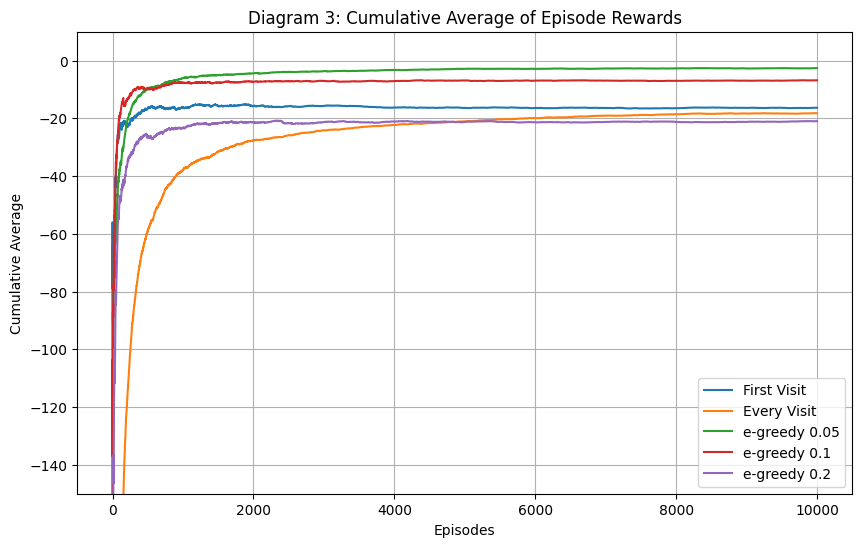

In [ ]:
# Calculate cumulative average
cumulative_average_fv = np.cumsum(episode_rewards_fv) / np.arange(1, len(episode_rewards_fv) + 1)
cumulative_average_ev = np.cumsum(episode_rewards_ev) / np.arange(1, len(episode_rewards_ev) + 1)
cumulative_average_egreedy5 = np.cumsum(episode_rewards_egreedy5) / np.arange(1, len(episode_rewards_egreedy5) + 1)
cumulative_average_egreedy10 = np.cumsum(episode_rewards_egreedy10) / np.arange(1, len(episode_rewards_egreedy10) + 1)
cumulative_average_egreedy20 = np.cumsum(episode_rewards_egreedy20) / np.arange(1, len(episode_rewards_egreedy20) + 1)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(cumulative_average_fv)
plt.plot(cumulative_average_ev)
plt.plot(cumulative_average_egreedy5)
plt.plot(cumulative_average_egreedy10)
plt.plot(cumulative_average_egreedy20)
plt.title('Diagram 3: Cumulative Average of Episode Rewards')
plt.xlabel('Episodes')
plt.ylabel('Cumulative Average')
plt.grid(True)
plt.ylim(-150, 10)
plt.legend(['First Visit', 'Every Visit', 'e-greedy 0.05', 'e-greedy 0.1', 'e-greedy 0.2'])
plt.show()

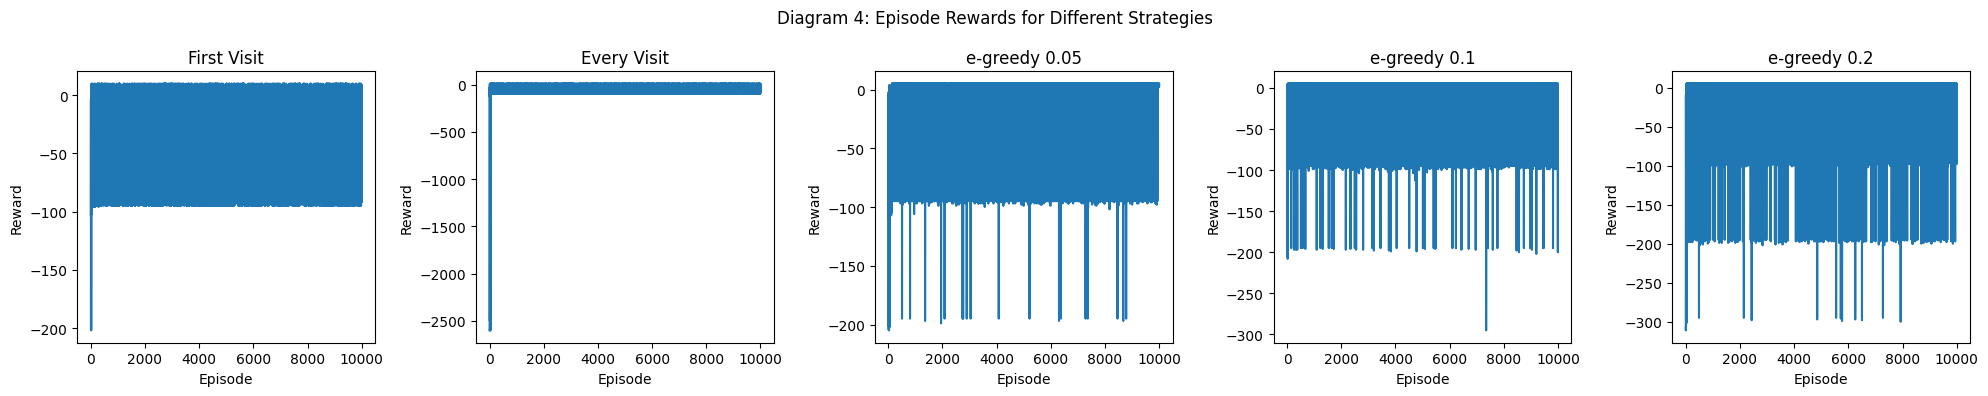

In [ ]:
# List of data and corresponding titles
data_lists = [episode_rewards_fv, episode_rewards_ev, episode_rewards_egreedy5, episode_rewards_egreedy10, episode_rewards_egreedy20]
titles = ['First Visit', 'Every Visit', 'e-greedy 0.05', 'e-greedy 0.1', 'e-greedy 0.2']

# Create the plot
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
fig.suptitle('Diagram 4: Episode Rewards for Different Strategies')

# Plot each dataset
for i, (data, title) in enumerate(zip(data_lists, titles)):
    axs[i].plot(data)
    axs[i].set_title(title)
    axs[i].set_xlabel('Episode')
    axs[i].set_ylabel('Reward')

# Adjust layout and display
plt.tight_layout()
plt.show()

From Diagram 3 and Diagram 4, we can note that the convergence properties of first-visit ES and the e-greedy methods are quite similar. They seem to converge slightly faster than the every-visit approach.

Furthermore, the every-visit approach and high-epsilon e-greedy approach display lower average returns.

Both of these tendencies are attributable to the nature of the methods. As for the every-visit method, we will take into account many more reward values throughout the episodes. Since the wall bouncing is severely negative, this affects the average reward. In the e-greedy high-epsilon case, it's attributable to the fact that suboptimal actions are chosen more often, since this setting encourages more exploration rather than exploitation. This is also highlighted by the variance of the different methods, as can be seen in Table 4.

In [ ]:
# Calculate variances
var_fv = np.var(episode_rewards_fv)
var_ev = np.var(episode_rewards_ev)
var_egreedy5 = np.var(episode_rewards_egreedy5)
var_egreedy10 = np.var(episode_rewards_egreedy10)
var_egreedy20 = np.var(episode_rewards_egreedy20)

# Define the data
data = [
    ["First-Visit", f"{var_fv:.1f}"],
    ["Every-Visit", f"{var_ev:.1f}"],
    ["ε-greedy (ε=0.05)", f"{var_egreedy5:.1f}"],
    ["ε-greedy (ε=0.10)", f"{var_egreedy10:.1f}"],
    ["ε-greedy (ε=0.20)", f"{var_egreedy20:.1f}"]
]

# Define the title
table_title = "Table 4: Variance of Episode Rewards"

# Create HTML table
html_table = f"""
<table style="border-collapse: collapse; width: 100%;">
  <caption style="caption-side: top; text-align: center; font-weight: bold; font-size: 1.2em; margin-bottom: 10px;">
    {table_title}
  </caption>
  <tr style="background-color: #f2f2f2;">
    <th style="border: 1px solid #ddd; padding: 8px; text-align: center;">Method</th>
    <th style="border: 1px solid #ddd; padding: 8px; text-align: center;">Variance</th>
  </tr>
"""

for row in data:
    html_table += f"""
  <tr>
    <td style="border: 1px solid #ddd; padding: 8px; text-align: center;">{row[0]}</td>
    <td style="border: 1px solid #ddd; padding: 8px; text-align: center;">{row[1]}</td>
  </tr>
"""

html_table += "</table>"

# Display the HTML table
HTML(html_table)

Method,Variance
First-Visit,1774.8
Every-Visit,6803.9
ε-greedy (ε=0.05),724.1
ε-greedy (ε=0.10),1131.7
ε-greedy (ε=0.20),2461.1


Concludingly: In this setting, the first-visit ES method or one of the low-epsilon e-greedy methods seem preferrable, due to both faster convergence, lower variance of rewards and higher average rewards.

The ES and e-greedy methods differs in other aspects as well, which is displayed in Diagram 5 below.

After convergence, all five of the different methods traverse from (0, 0) to (3, 3) in the minimum number of steps – six – albeit in slightly different ways. However, when starting in state (3, 0) or (0, 3), only the exploring starts-methods correctly and consistently identify the most effective way of getting to the goal. This is not surprising, given that the e-greedy methods always start in (0, 0) and will visit states like (3, 0) very seldomly once the policy has begun to converge. This means that the agent has less opportunity to learn the optimal action in those steps.

It's also worth noting that the corner states – where the agent has the highest risk of bouncing into a wall and getting a big negative punishment – display very low values.

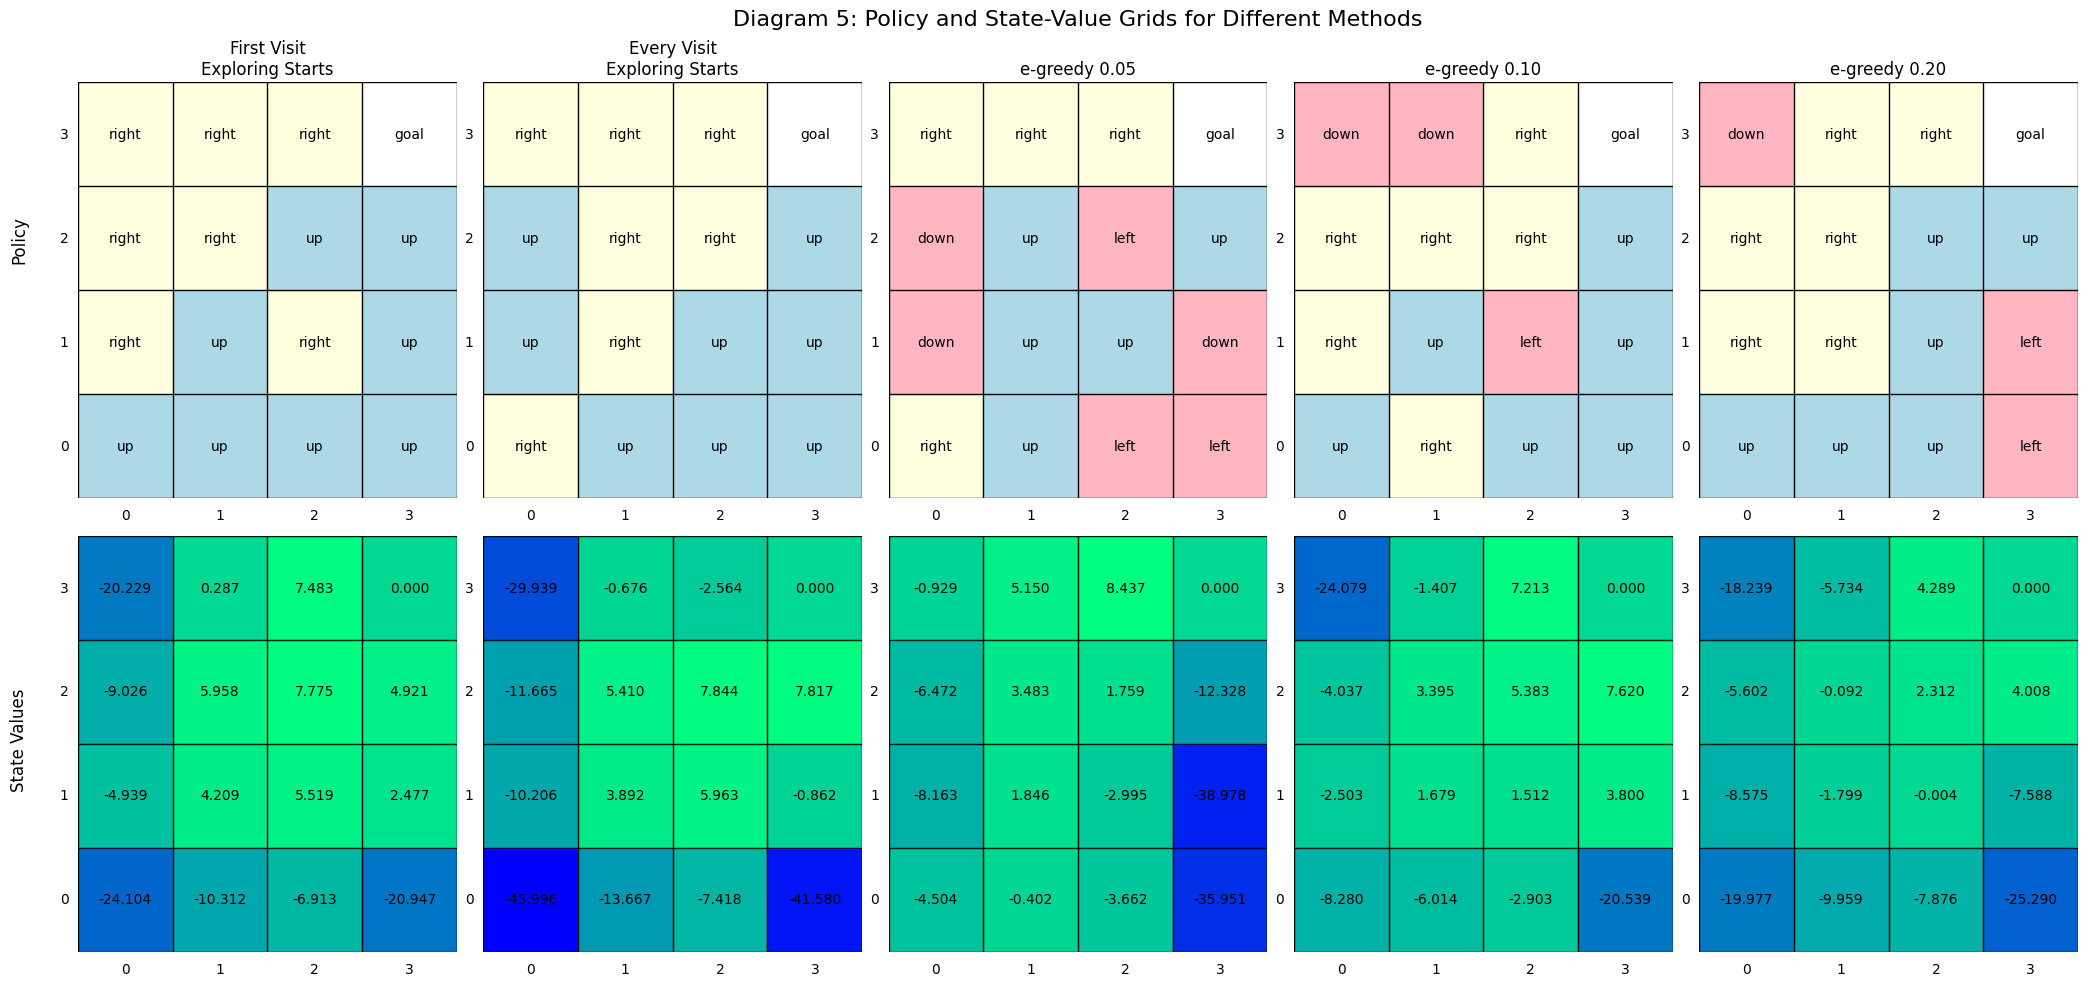

In [ ]:
methods = ['First Visit\nExploring Starts', 'Every Visit\nExploring Starts', 'e-greedy 0.05', 'e-greedy 0.10', 'e-greedy 0.20']
value_dicts = [V_fv, V_ev, V_egreedy5, V_egreedy10, V_egreedy20]
policy_dicts = [P_fv, P_ev, P_egreedy5, P_egreedy10, P_egreedy20]

fig, axs = plt.subplots(2, 5, figsize=(25, 10))
fig.suptitle('Diagram 5: Policy and State-Value Grids for Different Methods', fontsize=16)

# Define color mapping for policy
policy_colors = {'up': 'lightblue', 'down': 'lightpink', 'left': 'lightpink', 'right': 'lightyellow'}

# Find global min and max values for consistent color scaling
all_values = [value for V in value_dicts for value in V.values()]
vmin, vmax = min(all_values), max(all_values)

for col, (method, V, P) in enumerate(zip(methods, value_dicts, policy_dicts)):
    for row, data in enumerate([P, V]):
        ax = axs[row, col]
        ax.axis('off')

        # Create grid
        for i in range(5):
            ax.axhline(y=i, color='black', linewidth=1)
            ax.axvline(x=i, color='black', linewidth=1)

        # Add colored cells and text
        for (x, y), value in data.items():
            if row == 0:  # Policy
                color = policy_colors.get(value, 'white')
                ax.add_patch(plt.Rectangle((x, y), 1, 1, fill=True, color=color))
                ax.text(x + 0.5, y + 0.5, value, ha='center', va='center')
            else:  # State Values
                color = plt.cm.winter((value - vmin) / (vmax - vmin))
                ax.add_patch(plt.Rectangle((x, y), 1, 1, fill=True, color=color))
                ax.text(x + 0.5, y + 0.5, f'{value:.3f}', ha='center', va='center', color='black')

        # Set limits
        ax.set_xlim(0, 4)
        ax.set_ylim(0, 4)

        # Add coordinates
        for i in range(4):
            ax.text(i + 0.5, -0.1, str(i), ha='center', va='top')
            ax.text(-0.1, i + 0.5, str(i), ha='right', va='center')

        # Add method title only to the top row
        if row == 0:
            ax.set_title(method)

# Add row labels
fig.text(0.08, 0.75, 'Policy', ha='right', va='center', rotation='vertical', fontsize=12)
fig.text(0.08, 0.25, 'State Values', ha='right', va='center', rotation='vertical', fontsize=12)

plt.tight_layout()
plt.subplots_adjust(left=0.1, right=0.9)  # Adjust margins
plt.show()